In [2]:
#!pip install nibabel #https://github.com/nipy/nibabel


In [1]:
import SimpleITK as sitk

In [3]:
mesh = sitk.meshread('C:\\RaghusWork\\Data\\GarciaPNAS2018_zp_K65Z\\PMA28to30\\noninjured_ab.L.configincaltrelaxaverage.anat.reg.surf.gii')

AttributeError: module 'SimpleITK' has no attribute 'meshread'

In [ ]:
#https://vtkusers.public.kitware.narkive.com/J6TNTBbW/delaunay-surface-triangulation-in-3d
#vtkDelaunay2D: ignoring the Z-coordinate during its triangulation) 
#vtkDelaunay3D: a tetrahedral mesh
#vtkGeometryFilter will extract surface cells from a volumetric mesh.
'''
vtkDelaunay3D* delny = vtkDelaunay3D::New();
delny->SetInput(pPolyData);
delny->SetTolerance(0.001);
delny->Update();
vtkGeometryFilter* geom = vtkGeometryFilter::New();
geom->SetInput( delny->GetOutput() );
geom->Update();
'''

In [1]:
#!pip install openpyxl
import numpy as np
import pandas as pd
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
#ax = plt.axes(projection="3d")

In [2]:
def triangulateFunctionGraph(ax, XYZ, cmap=cm.magma):
    tri = Delaunay(XYZ[:,:2]) # triangulate projections
    ax.plot_trisurf(
        XYZ[:,0], XYZ[:,1], XYZ[:,2], triangles=tri.simplices, cmap=cmap)
    
def readFace(file):
    with open(file, 'r') as vertices:
        return np.array([
            [float(v) for v in line.split()] for line in vertices])

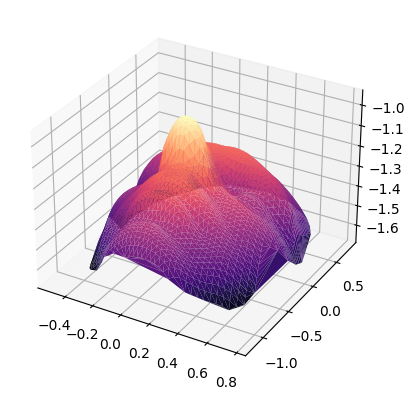

In [9]:
xyz = readFace('face.vert')
xyz.shape; xyz[1:5,:]
ax = plt.axes(projection="3d")
triangulateFunctionGraph(ax, xyz)
plt.show()

In [11]:
# take n x 3 array of points of the form (x, y, f(x,y))
def generatePointsOnSphere(k):
#Parameterization: (cos(u) sin(v), sin(u) sin(v), cos(v)) 
#where u goes from 0 to 2π and v goes from 0 to π.
    # domain parametrization
    U = np.linspace(0, 2 * np.pi, k)
    V = np.linspace(0, np.pi, k)
    [X, Y] = np.meshgrid(U, V)

    # sphere parametrization
    S1 = np.cos(X) * np.sin(Y)
    S2 = np.sin(X) * np.sin(Y)
    S3 = np.cos(Y)
    
    # triangulate the points in [0,2pi] x [0,pi]
    tri = Delaunay(np.array([X.flatten(), Y.flatten()]).T)
    #return S1, S2, S3 
    return np.column_stack((S1.flatten(), S2.flatten(), S3.flatten()))

def generatePointsOnEllipsoid(A, k):
    # domain parametrization
    U = np.linspace(0, 2 * np.pi, k)
    V = np.linspace(0, np.pi, k)
    [X, Y] = np.meshgrid(U, V)

    # sphere parametrization
    S1 = np.cos(X) * np.sin(Y)
    S2 = np.sin(X) * np.sin(Y)
    S3 = np.cos(Y)

    # map sphere to elipsoid
    E1 = np.zeros((k,k))
    E2 = np.zeros((k,k))
    E3 = np.zeros((k,k))
    for i in range(k):
        for j in range(k):
            xyz = np.array([S1[i,j], S2[i,j], S3[i,j]])
            [E1[i,j], E2[i,j], E3[i,j]] = A @ xyz
            
    return np.column_stack((E1.flatten(), E2.flatten(), E3.flatten()))

def generatePointsOnTorus(k=200, a=2, b=9):
    # domain parametrization
    U = np.linspace(0, 2 * np.pi, k)
    V = np.linspace(0, 2 * np.pi, k)
    [X, Y] = np.meshgrid(U, V)

    # Torus parametrization
    T1 = (b + a*np.cos(U)) * np.cos(V)
    T2 = (b + a*np.cos(U)) * np.sin(V)
    T3 = a * np.sin(U)

    ''' torus = lambda a, b: (
    lambda x, y: (a * cos(y) + b) * cos(x),
    lambda x, y: (a * cos(y) + b) * sin(x),
    lambda x, y: a * sin(y)
    )'''
    return np.column_stack((T1.flatten(), T2.flatten(), T3.flatten()))

In [ ]:
def generatePointsOnBagel(k=200, a=2, b=9):
    # domain parametrization
    U = np.linspace(0, 2 * np.pi, k)
    V = np.linspace(0, 2 * np.pi, k)
    [X, Y] = np.meshgrid(U, V)

    # Torus parametrization
    T1 = (b + a*np.cos(U)) * np.cos(V)
    T2 = (b + a*np.cos(U)) * np.sin(V)
    T3 = a * np.sin(U)

    ''' kleinBagel = lambda r: (
    lambda x, y: (r + cos(x/2) * sin(y) - sin(x/2) * sin(2*y)) * cos(x),
    lambda x, y: (r + cos(x/2) * sin(y) - sin(x/2) * sin(2*y)) * sin(x),
    lambda x, y: sin(x/2) * sin(y) + cos(x/2) * sin(2*y)
    )'''
    return np.column_stack((T1.flatten(), T2.flatten(), T3.flatten()))

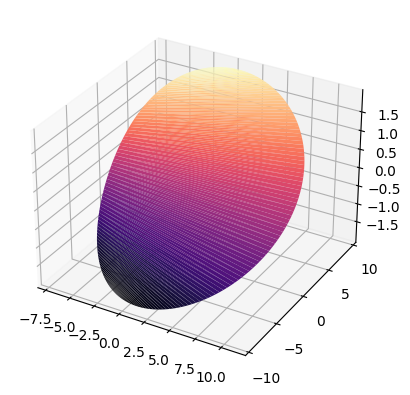

In [25]:
k = 200
xyz = generatePointsOnTorus(k, 2, 9)
#len(torus)
ax = plt.axes(projection="3d")
triangulateFunctionGraph(ax, xyz)
plt.show()

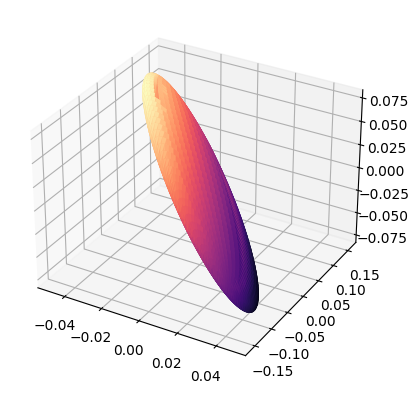

In [13]:
k = 50
#xyz = generatePointsOnSphere(k)

A = np.array([
    [-0.01289453, -0.02087514,  0.04109751],
    [-0.00261222, -0.01984956, -0.15409974],
    [-0.00431062,  0.07447336, -0.0295528 ]
])
xyz = generatePointsOnEllipsoid(A, k)
ax = plt.axes(projection="3d")
triangulateFunctionGraph(ax, xyz)
plt.show()

In [ ]:
#Triangulating two other surfaces
# (x, y) in [0,2pi] x [0,2pi]
torus = lambda a, b: (
    lambda x, y: (a * cos(y) + b) * cos(x),
    lambda x, y: (a * cos(y) + b) * sin(x),
    lambda x, y: a * sin(y)
)
# (x, y) in [0,2pi] x [0,2pi]
kleinBagel = lambda r: (
    lambda x, y: (r + cos(x/2) * sin(y) - sin(x/2) * sin(2*y)) * cos(x),
    lambda x, y: (r + cos(x/2) * sin(y) - sin(x/2) * sin(2*y)) * sin(x),
    lambda x, y: sin(x/2) * sin(y) + cos(x/2) * sin(2*y)
)

In [ ]:
w27_31vertices = pd.read_excel(w27_31verticesFile, header=None, engine='openpyxl') #.replace('/','\\') 
w31_27vertices = pd.read_excel(w31_27verticesFile, header=None, engine='openpyxl')
w27_31triangles = pd.read_csv(w27_31trianglesFile, sep=',', header=None)

In [ ]:
print(len(w27_31vertices.index),len(w31_27vertices.index),len(w27_31triangles.index))
print(w27_31vertices.shape, w31_27vertices.shape, w27_31triangles.shape)
#w27_31vertices.head(), w31_27vertices.head(), w27_31triangles.head()

In [ ]:
#compute growth vectors
growthVector = w31_27vertices - w27_31vertices
#len(w27_31vertices.index)
#w27_31vertices.head(), w31_27vertices.head(), growthVector.head()

In [ ]:
a0 = []; a1 = []; a2 = [];
b0 = []; b1 = []; b2 = [];
c0 = []; c1 = []; c2 = [];
for index, edges in w27_31triangles.iterrows():
    #if (index>2):
    #    break
    vertex0 = w27_31vertices.iloc[edges[0]].to_numpy()
    vertex1 = w27_31vertices.iloc[edges[1]].to_numpy()
    vertex2 = w27_31vertices.iloc[edges[2]].to_numpy()
    normal = np.cross(vertex1-vertex0, vertex2-vertex0)
    G0 = growthVector.iloc[edges[0]].to_numpy()
    G1 = growthVector.iloc[edges[1]].to_numpy()
    G2 = growthVector.iloc[edges[2]].to_numpy()
    n2 = np.dot(normal,normal)
    a = np.cross((G1[0]-G0[0])*normal,(vertex0-vertex2)) + np.cross((G2[0]-G0[0])*normal,(vertex1-vertex0))
    a = a/n2
    a0.append(a[0]); a1.append(a[1]); a2.append(a[2]);
    b = np.cross((G1[1]-G0[1])*normal,(vertex0-vertex2)) + np.cross((G2[1]-G0[1])*normal,(vertex1-vertex0))
    b = b/n2
    b0.append(b[0]); b1.append(b[1]); b2.append(b[2]);
    c = np.cross((G1[2]-G0[2])*normal,(vertex0-vertex2)) + np.cross((G2[2]-G0[2])*normal,(vertex1-vertex0))
    c = c/n2
    c0.append(c[0]); c1.append(c[1]); c2.append(c[2]);
    #print(edges[0],edges[1],edges[2])  
    #print(vertex0,vertex1,vertex2,normal,n2)
    #print(a,b,c)
outDf = pd.DataFrame({'a0': a0, 'a1': a1, 'a2': a2, 'b0': b0, 'b1': b1, 'b2': b2, 'c0': c0, 'c1': c1, 'c2': c2})
outDf.to_excel("co-efficients.xlsx") #, startrow=1)
outDf.head()

In [ ]:
import numpy as np
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

ax = plt.figure().gca(projection='3d')